In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_colwidth', -1)

df_amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None)
df_amazon.columns = ['message', 'score'] # score of 1=positive, 0=negative

df_imdb = pd.read_csv('imdb_labelled.txt', delimiter='\t', names=['message', 'score'])

df_yelp = pd.read_csv('yelp_labelled.txt', delimiter='\t', names=['message', 'score'])

We are trying to use a Naive Bayes seniment classifier to predict whether or not a comment on a website is positive or negative.  To start we will create a list of keywords to search for in the comments to classify by.  The keywords should all correspond to a positive comment.

In [2]:
def split_goods_and_bads(df):
    goods = df[df['score']==1]
    bads = df[df['score']==0]
    return goods, bads

goods, bads = split_goods_and_bads(df_amazon)
#print(goods.iloc[50:200,0])

In [3]:
keywords = ['good', 'great', 'best', 'excellent', 'awesome', 'fantastic', 'would recommend', 
            'must have', 'amazing', 'highly recommend', 'love', 'happy', 'glad', 'satisfied',
           'really like', 'well']

def naive_bayes_classifier(df,n=10):
    for key in keywords:
        df[str(key)]=df.message.str.contains(str(key), case=False)
    
    data = df[keywords]
    target = df['score']
    bnb = BernoulliNB()
    bnb.fit(data, target)
    y_pred = bnb.predict(data)

    print('Number of mislabelled points out of total {}: {}'.format(df.shape[0], (target!=y_pred).sum()))
    print('Performance = {:05.2f}%'.format(100*(1-(target!=y_pred).sum()/df.shape[0])))
    print('Baseline: {}'.format(df.score.sum()))
    print('')
    
    confusion = pd.DataFrame(confusion_matrix(target, y_pred))
    confusion.index = ['Actual Bad', 'Actual Good']
    confusion.columns = ['Predicted Bad', 'Predicted Good']
    print(confusion)
    print('')
    
    sensativity = (confusion.iloc[1,1]/confusion.iloc[1,:].sum())*100
    specificity = (confusion.iloc[0,0]/confusion.iloc[0,:].sum())*100
    print('Sensativity = {:05.2f}%'.format(sensativity))
    print('Specificity = {0:05.2f}%'.format(specificity))
    print('')
    
    print('Cross validation')
    crossval = cross_val_score(bnb, data, target, cv=n)
    print(crossval)
    print(crossval.var())
    print('')
    
    feature_probs = bnb.feature_log_prob_
    zipped = dict(zip(keywords,feature_probs[0]))
    feature_prob_df = pd.DataFrame()
    feature_prob_df['Feature'] = keywords
    feature_prob_df['log_probability'] = zipped.values()
    listofprobs = list(zipped.values())
    feature_prob_df['probability'] = np.exp(listofprobs)
    print(feature_prob_df.sort_values(by='log_probability', ascending=False))
    print('')

    sns.heatmap(data.corr(), cmap='RdBu')
    plt.show()

Number of mislabelled points out of total 1000: 249
Performance = 75.10%
Baseline: 500

             Predicted Bad  Predicted Good
Actual Bad   467            33            
Actual Good  216            284           

Sensativity = 56.80%
Specificity = 93.40%

Cross validation
[0.82 0.72 0.8  0.74 0.81 0.76 0.67 0.73 0.78 0.67]
0.0026199999999999995

             Feature  log_probability  probability
0   good             -3.579543         0.027888   
15  well             -4.139159         0.015936   
1   great            -4.272690         0.013944   
11  happy            -4.609162         0.009960   
2   best             -5.119988         0.005976   
3   excellent        -5.525453         0.003984   
4   awesome          -6.218600         0.001992   
5   fantastic        -6.218600         0.001992   
6   would recommend  -6.218600         0.001992   
7   must have        -6.218600         0.001992   
8   amazing          -6.218600         0.001992   
9   highly recommend -6.218600     

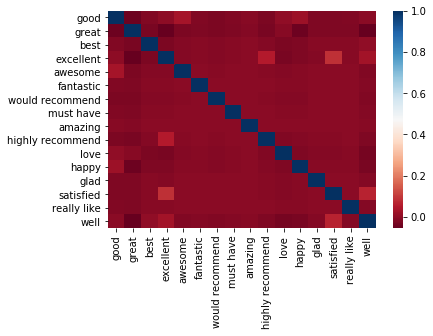

In [4]:
naive_bayes_classifier(df_amazon)

This model above performed well.  It does not seem to be overfitting (maybe a little because there is some discrepancy in the cross validation).  It appears that the features "good", "well", "great", and "happy" rank the highest.

In [5]:
#naive_bayes_classifier(df_imdb)

In [6]:
#naive_bayes_classifier(df_yelp)

The model below is the same model above only now we are trying to identify some of the bad keywords at the same time.

In [7]:
goodkeywords = ['good', 'great', 'best', 'excellent', 'awesome', 'fantastic', 'would recommend', 
            'must have', 'amazing', 'highly recommend', 'love', 'happy', 'glad', 'satisfied', 'perfect',
           'really like', 'well']
badkeywords = ['bad', 'terrible', 'hate', 'not recommend', 'awful', 'problem', 'worthless', 'garbage', 'no way']


def naive_bayes_classifier1(df,n=10):
    for key in goodkeywords:
        df[str(key)]=df.message.str.contains(str(key), case=False)
    for key in badkeywords:
        df[str(key)]=~df.message.str.contains(str(key), case=False)
    
    data = df[goodkeywords+badkeywords]
    target = df['score']
    bnb = BernoulliNB()
    bnb.fit(data, target)
    y_pred = bnb.predict(data)

    print('Number of mislabelled points out of total {}: {}'.format(df.shape[0], (target!=y_pred).sum()))
    print('Performance = {:05.2f}%'.format(100*(1-(target!=y_pred).sum()/df.shape[0])))
    print('Baseline: {}'.format(df.score.sum()))
    print('')
    
    confusion = pd.DataFrame(confusion_matrix(target, y_pred))
    confusion.index = ['Actual Bad', 'Actual Good']
    confusion.columns = ['Predicted Bad', 'Predicted Good']
    print(confusion)
    print('')
    
    sensativity = (confusion.iloc[1,1]/confusion.iloc[1,:].sum())*100
    specificity = (confusion.iloc[0,0]/confusion.iloc[0,:].sum())*100
    print('Sensativity = {:05.2f}%'.format(sensativity))
    print('Specificity = {0:05.2f}%'.format(specificity))
    print('')
    
    print('Cross validation')
    crossval = cross_val_score(bnb, data, target, cv=n)
    print(crossval)
    print(crossval.var())
    print('')
    
    keywords = goodkeywords + badkeywords
    feature_probs = bnb.feature_log_prob_
    zipped = dict(zip(keywords, feature_probs[0]))
    feature_prob_df = pd.DataFrame()
    feature_prob_df['Feature'] = keywords
    feature_prob_df['log_probability'] = zipped.values()
    listofprobs = list(zipped.values())
    feature_prob_df['probability'] = np.exp(listofprobs)
    print(feature_prob_df.sort_values(by='log_probability', ascending=False))
    print('')

    sns.heatmap(data.corr(), cmap='RdBu')
    plt.show()

Number of mislabelled points out of total 1000: 246
Performance = 75.40%
Baseline: 500

             Predicted Bad  Predicted Good
Actual Bad   467            33            
Actual Good  213            287           

Sensativity = 57.40%
Specificity = 93.40%

Cross validation
[0.82 0.72 0.81 0.74 0.82 0.76 0.64 0.72 0.78 0.68]
0.0033289999999999986

             Feature  log_probability  probability
25  no way           -0.003992         0.996016   
24  garbage          -0.003992         0.996016   
23  worthless        -0.008000         0.992032   
21  awful            -0.008000         0.992032   
20  not recommend    -0.010010         0.990040   
19  hate             -0.012024         0.988048   
18  terrible         -0.022156         0.978088   
17  bad              -0.030336         0.970120   
22  problem          -0.032391         0.968127   
0   good             -3.579543         0.027888   
16  well             -4.139159         0.015936   
1   great            -4.272690     

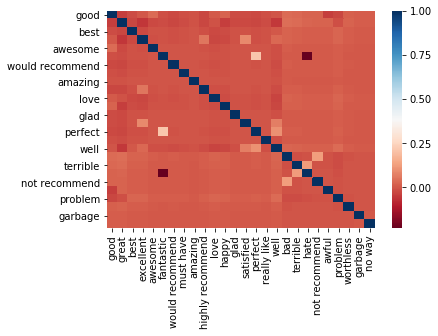

In [8]:
naive_bayes_classifier1(df_amazon)

The model below is attempting to use only the top features.

In [9]:
keywords2 = ['good', 'great', 'happy', 'best']


def naive_bayes_classifier2(df,n=10):
    for key in keywords2:
        df[str(key)]=df.message.str.contains(str(key), case=False)
    
    data = df[keywords2]
    target = df['score']
    bnb = BernoulliNB()
    bnb.fit(data, target)
    y_pred = bnb.predict(data)

    print('Number of mislabelled points out of total {}: {}'.format(df.shape[0], (target!=y_pred).sum()))
    print('Performance = {:05.2f}%'.format(100*(1-(target!=y_pred).sum()/df.shape[0])))
    print('Baseline: {}'.format(df.score.sum()))
    print('')
    
    confusion = pd.DataFrame(confusion_matrix(target, y_pred))
    confusion.index = ['Actual Bad', 'Actual Good']
    confusion.columns = ['Predicted Bad', 'Predicted Good']
    print(confusion)
    print('')
    
    sensativity = (confusion.iloc[1,1]/confusion.iloc[1,:].sum())*100
    specificity = (confusion.iloc[0,0]/confusion.iloc[0,:].sum())*100
    print('Sensativity = {:05.2f}%'.format(sensativity))
    print('Specificity = {0:05.2f}%'.format(specificity))
    print('')
    
    print('Cross validation')
    crossval = cross_val_score(bnb, data, target, cv=n)
    print(crossval)
    print(crossval.var())
    print('')
    
    feature_probs = bnb.feature_log_prob_
    zipped = dict(zip(keywords2,feature_probs[0]))
    feature_prob_df = pd.DataFrame()
    feature_prob_df['Feature'] = keywords2
    feature_prob_df['log_probability'] = zipped.values()
    listofprobs = list(zipped.values())
    feature_prob_df['probability'] = np.exp(listofprobs)
    print(feature_prob_df.sort_values(by='log_probability', ascending=False))
    print('')

    sns.heatmap(data.corr(), cmap='RdBu')
    plt.show()

Number of mislabelled points out of total 1000: 346
Performance = 65.40%
Baseline: 500

             Predicted Bad  Predicted Good
Actual Bad   475            25            
Actual Good  321            179           

Sensativity = 35.80%
Specificity = 95.00%

Cross validation
[0.68 0.67 0.72 0.65 0.65 0.68 0.59 0.63 0.66 0.61]
0.0012640000000000008

  Feature  log_probability  probability
0  good   -3.579543         0.027888   
1  great  -4.272690         0.013944   
2  happy  -4.609162         0.009960   
3  best   -5.119988         0.005976   



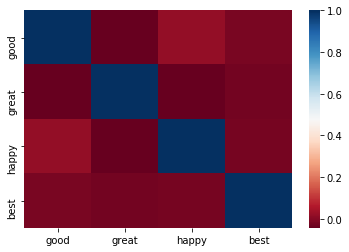

In [10]:
naive_bayes_classifier2(df_amazon)

The model below is attempting to overfit the data by using specific terms found from a direct search of only the 'goods'.  Interestingly, it did not seem to overfit the model, but actually create the strongest model for the amazon data set.

In [11]:
keywords3 = ['good', 'great', 'best', 'excellent', 'awesome', 'fantastic', 'would recommend', 
            'must have', 'amazing', 'highly recommend', 'love', 'happy', 'glad', 'satisfied', 
           'really like', 'well', 'seamless', 'comfortable', 'pleased', 'fast shipping', 'brilliant', 'no problem', 
            'easy to use', 'cool', 'tremendous']

def naive_bayes_classifier3(df,n=10):
    for key in keywords3:
        df[str(key)]=df.message.str.contains(str(key), case=False)
    
    data = df[keywords3]
    target = df['score']
    bnb = BernoulliNB()
    bnb.fit(data, target)
    y_pred = bnb.predict(data)

    print('Number of mislabelled points out of total {}: {}'.format(df.shape[0], (target!=y_pred).sum()))
    print('Performance = {:05.2f}%'.format(100*(1-(target!=y_pred).sum()/df.shape[0])))
    print('Baseline: {}'.format(df.score.sum()))
    print('')
    
    confusion = pd.DataFrame(confusion_matrix(target, y_pred))
    confusion.index = ['Actual Bad', 'Actual Good']
    confusion.columns = ['Predicted Bad', 'Predicted Good']
    print(confusion)
    print('')
    
    sensativity = (confusion.iloc[1,1]/confusion.iloc[1,:].sum())*100
    specificity = (confusion.iloc[0,0]/confusion.iloc[0,:].sum())*100
    print('Sensativity = {:05.2f}%'.format(sensativity))
    print('Specificity = {0:05.2f}%'.format(specificity))
    print('')
    
    print('Cross validation')
    crossval = cross_val_score(bnb, data, target, cv=n)
    print(crossval)
    print(crossval.var())
    print('')
    
    feature_probs = bnb.feature_log_prob_
    zipped = dict(zip(keywords3,feature_probs[0]))
    feature_prob_df = pd.DataFrame()
    feature_prob_df['Feature'] = keywords3
    feature_prob_df['log_probability'] = zipped.values()
    listofprobs = list(zipped.values())
    feature_prob_df['probability'] = np.exp(listofprobs)
    print(feature_prob_df.sort_values(by='log_probability', ascending=False))
    print('')

    sns.heatmap(data.corr(), cmap='RdBu')
    plt.show()

Number of mislabelled points out of total 1000: 231
Performance = 76.90%
Baseline: 500

             Predicted Bad  Predicted Good
Actual Bad   458            42            
Actual Good  189            311           

Sensativity = 62.20%
Specificity = 91.60%

Cross validation
[0.83 0.75 0.81 0.77 0.81 0.76 0.68 0.75 0.79 0.68]
0.002380999999999999

             Feature  log_probability  probability
0   good             -3.579543         0.027888   
15  well             -4.139159         0.015936   
17  comfortable      -4.272690         0.013944   
1   great            -4.272690         0.013944   
11  happy            -4.609162         0.009960   
2   best             -5.119988         0.005976   
23  cool             -5.119988         0.005976   
3   excellent        -5.525453         0.003984   
18  pleased          -5.525453         0.003984   
22  easy to use      -6.218600         0.001992   
21  no problem       -6.218600         0.001992   
20  brilliant        -6.218600      

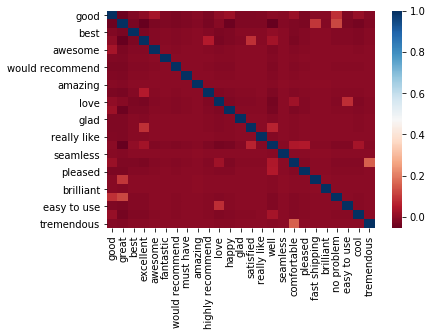

In [12]:
naive_bayes_classifier3(df_amazon)

This model below is built only on the key bad words.  If the bad keyword is identified in the message the opposite boolean is displayed in an attempt to identify the good messages.

In [13]:
badkeywords = ['bad', 'terrible', 'hate', 'not recommend', 'awful', 'problem', 'worthless', 'garbage', 'no way', 'not']

def naive_bayes_classifier4(df,n=10):
    for key in badkeywords:
        df[str(key)]=~df.message.str.contains(str(key), case=False)
    
    data = df[badkeywords]
    target = df['score']
    bnb = BernoulliNB()
    bnb.fit(data, target)
    y_pred = bnb.predict(data)

    print('Number of mislabelled points out of total {}: {}'.format(df.shape[0], (target!=y_pred).sum()))
    print('Performance = {:05.2f}%'.format(100*(1-(target!=y_pred).sum()/df.shape[0])))
    print('Baseline: {}'.format(df.score.sum()))
    print('')
    
    confusion = pd.DataFrame(confusion_matrix(target, y_pred))
    confusion.index = ['Actual Bad', 'Actual Good']
    confusion.columns = ['Predicted Bad', 'Predicted Good']
    print(confusion)
    print('')
    
    sensativity = (confusion.iloc[1,1]/confusion.iloc[1,:].sum())*100
    specificity = (confusion.iloc[0,0]/confusion.iloc[0,:].sum())*100
    print('Sensativity = {:05.2f}%'.format(sensativity))
    print('Specificity = {0:05.2f}%'.format(specificity))
    print('')
    
    print('Cross validation')
    crossval = cross_val_score(bnb, data, target, cv=n)
    print(crossval)
    print(crossval.var())
    print('')
    
    keywords = badkeywords
    feature_probs = bnb.feature_log_prob_
    zipped = dict(zip(keywords, feature_probs[0]))
    feature_prob_df = pd.DataFrame()
    feature_prob_df['Feature'] = keywords
    feature_prob_df['log_probability'] = zipped.values()
    listofprobs = list(zipped.values())
    feature_prob_df['probability'] = np.exp(listofprobs)
    print(feature_prob_df.sort_values(by='log_probability', ascending=False))
    print('')

    sns.heatmap(data.corr(), cmap='RdBu')
    plt.show()

Number of mislabelled points out of total 1000: 377
Performance = 62.30%
Baseline: 500

             Predicted Bad  Predicted Good
Actual Bad   152            348           
Actual Good  29             471           

Sensativity = 94.20%
Specificity = 30.40%

Cross validation
[0.62 0.65 0.6  0.61 0.67 0.53 0.64 0.59 0.64 0.59]
0.0014240000000000006

         Feature  log_probability  probability
7  garbage       -0.003992         0.996016   
8  no way        -0.003992         0.996016   
4  awful         -0.008000         0.992032   
6  worthless     -0.008000         0.992032   
3  not recommend -0.010010         0.990040   
2  hate          -0.012024         0.988048   
1  terrible      -0.022156         0.978088   
0  bad           -0.030336         0.970120   
5  problem       -0.032391         0.968127   
9  not           -0.252453         0.776892   



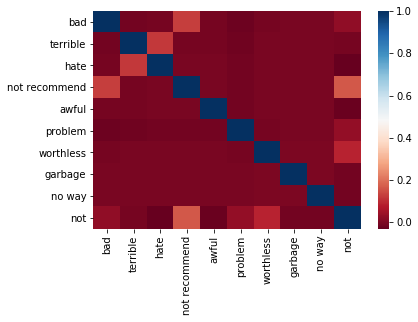

In [14]:
naive_bayes_classifier4(df_amazon)

This model is identifying the bad keywords as bad - to see the difference between the two bad keywords models.  This suprisingly did not have any difference from the model above.

In [17]:
badkeywords = ['bad', 'terrible', 'hate', 'not recommend', 'awful', 'problem', 'worthless', 'garbage', 'no way', 'not']

def naive_bayes_classifier5(df,n=10):
    for key in badkeywords:
        df[str(key)]=df.message.str.contains(str(key), case=False)
    
    data = df[badkeywords]
    target = df['score']
    bnb = BernoulliNB()
    bnb.fit(data, target)
    y_pred = bnb.predict(data)

    print('Number of mislabelled points out of total {}: {}'.format(df.shape[0], (target!=y_pred).sum()))
    print('Performance = {:05.2f}%'.format(100*(1-(target!=y_pred).sum()/df.shape[0])))
    print('Baseline: {}'.format(df.score.sum()))
    print('')
    
    confusion = pd.DataFrame(confusion_matrix(target, y_pred))
    confusion.index = ['Actual Bad', 'Actual Good']
    confusion.columns = ['Predicted Bad', 'Predicted Good']
    print(confusion)
    print('')
    
    sensativity = (confusion.iloc[1,1]/confusion.iloc[1,:].sum())*100
    specificity = (confusion.iloc[0,0]/confusion.iloc[0,:].sum())*100
    print('Sensativity = {:05.2f}%'.format(sensativity))
    print('Specificity = {0:05.2f}%'.format(specificity))
    print('')
    
    print('Cross validation')
    crossval = cross_val_score(bnb, data, target, cv=n)
    print(crossval)
    print(crossval.var())
    print('')
    
    keywords = badkeywords
    feature_probs = bnb.feature_log_prob_
    zipped = dict(zip(keywords, feature_probs[0]))
    feature_prob_df = pd.DataFrame()
    feature_prob_df['Feature'] = keywords
    feature_prob_df['log_probability'] = zipped.values()
    listofprobs = list(zipped.values())
    feature_prob_df['probability'] = np.exp(listofprobs)
    print(feature_prob_df.sort_values(by='log_probability', ascending=False))
    print('')

    sns.heatmap(data.corr(), cmap='RdBu')
    plt.show()

Number of mislabelled points out of total 1000: 377
Performance = 62.30%
Baseline: 500

             Predicted Bad  Predicted Good
Actual Bad   152            348           
Actual Good  29             471           

Sensativity = 94.20%
Specificity = 30.40%

Cross validation
[0.62 0.65 0.6  0.61 0.67 0.53 0.64 0.59 0.64 0.59]
0.0014240000000000006

         Feature  log_probability  probability
9  not           -1.500101         0.223108   
5  problem       -3.446011         0.031873   
0  bad           -3.510550         0.029880   
1  terrible      -3.820705         0.021912   
2  hate          -4.426841         0.011952   
3  not recommend -4.609162         0.009960   
4  awful         -4.832306         0.007968   
6  worthless     -4.832306         0.007968   
7  garbage       -5.525453         0.003984   
8  no way        -5.525453         0.003984   



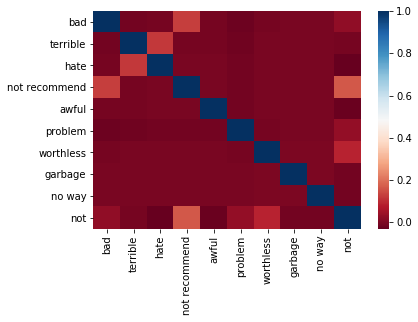

In [18]:
naive_bayes_classifier5(df_amazon)

For modelling the amazon data set I would choose the **naive_bayes_classifier3** as the model that performed the best.

This model performed the best because it had the highest accuracy, and sensativity and the variance across the cross validation is lower than the other two models that performed similarly (naive_bayes_classifier and naive_bayes_classifier1).  The tradeoff here is that this model does have the lowest specificity.  Therefore, this model has the highest performance and is the best at identifying true positives at the expense of being the worst model at identifying true negatives.

#### Points to touch on....

* want to add a ROC curve
* is my interpretation about ranking the features correct?
    * is there a better way?
* if my cross validation is telling me that my model is too overfit - should I trade accuracy for a better validation?
